# GD and BCGD Optimization Methods in Semi-supervised Learning

Author: Zesen.Huang   
Create time: 11/05/2021

In [29]:
import time
import numpy as np
import matplotlib as mplot
import matplotlib.pyplot as plt
import sklearn.preprocessing as sp
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
%matplotlib inline

##  Introduction
In this report, we artificially create a two-dimensional data set containing labeled and unlabeled data, and then predict the unlabeled data through the learning of labeled data. How to use GD and BCGD optimization methods in semi-supervised learning process is discussed by constructing loss function and finding its minimum value. In this project, we used Python to write all the programs and diagrams.

## Randomly generates label and unmarked data

First, we generate 1000 two-dimensional data points (x, y), including 100 label data and 900 unmarked data. The label data is divided into two classes, one labeled with 1 and one labeled with -1. In this project, the same feature represents the same label.

X_unlabel: (900, 2)
X_label: (100, 2)
y_unlabel_: (900,)
y_label_: (100,)


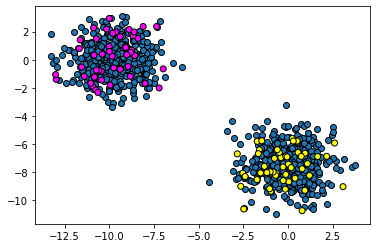

In [2]:
from sklearn.datasets import make_blobs 
from sklearn.neighbors import KNeighborsClassifier 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data = make_blobs(n_samples=1000, centers=2, cluster_std=1.2, random_state=9)
X, y = data
X_unlabel, X_label, y_unlabel, y_label = train_test_split(X, y, test_size=0.1, random_state=5)

# better to use -1 and 1
y_unlabel_ = np.ones_like(y_unlabel)
y_unlabel_[y_unlabel==0] = -1
y_unlabel = y_unlabel_

y_label_ = np.ones_like(y_label)
y_label_[y_label==0] = -1
y_label = y_label_

print('X_unlabel:',X_unlabel.shape)
print('X_label:',X_label.shape)
print('y_unlabel_:',y_unlabel_.shape)
print('y_label_:',y_label_.shape)

plt.scatter(X_unlabel[:,0], X_unlabel[:,1],cmap=plt.cm.spring, edgecolor='k')
plt.scatter(X_label[:,0], X_label[:,1], c=y_label, cmap=plt.cm.spring, edgecolor='k')
plt.show()

##  Similarity measure

### Using cosine similarity to determine the weight

$$
\textit{cosine_similarity}(u, v) = \frac{{\bf u} \cdot {\bf v}}{||{\bf u}||~||{\bf v}||} = \frac{\sum_{i=1}^n u_i~v_i}{\sqrt{\sum_{i=1}^n u_i^2}~\sqrt{\sum_{i=1}^n v_i^2}}
$$

In [3]:
def cosine_similarity_(u, v, norm=False): ###
    cos = np.dot(v, u.T)/(np.linalg.norm(u, axis=-1) * np.linalg.norm(v, axis=-1).reshape(1,v.shape[0]).T) ###
    return 0.5 * cos + 0.5 if norm else cos

def cosine_similarity(u, v, norm=False):
    cos = np.dot(u, v.T)/(np.linalg.norm(u, axis=-1) * np.linalg.norm(v, axis=-1))
    return 0.5 * cos + 0.5 if norm else cos

weight1 = cosine_similarity_(X_unlabel, X_label, norm=True)
print('weight1:',weight1.shape)

weight2 = cosine_similarity_(X_unlabel, X_unlabel, norm=True)
print('weight2:',weight2.shape)
print(weight2[1][2]==weight2[2][1])
# print(weight2[1])

### test
# a = np.array([[1,2],
#              [1,2]])
# print('new:')
# print(cosine_similarity_(a,a)) ###correct
# print('old')
# print(cosine_similarity(a,a))

weight1: (100, 900)
weight2: (900, 900)
True


Ideally, the smaller the weight, the different the class, and the larger the weight, the same. So ideally, each row should be very large, such as going straight to 1, and very small to go straight to 0, with little (or very little) other values in between. The dividing line of weight determined by cosine_similarity_ is not obvious and is not suitable.

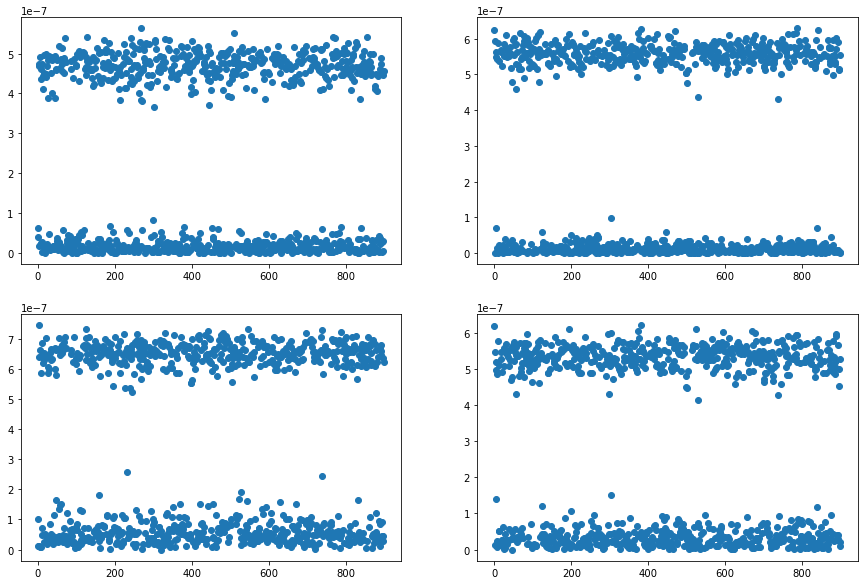

In [14]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax1 = plt.scatter(range(900), weight2[369])

ax2 = fig.add_subplot(222)
ax2 = plt.scatter(range(900), weight2[99])

ax3 = fig.add_subplot(223)
ax3 = plt.scatter(range(900), weight2[321])

ax4 = fig.add_subplot(224)
ax4 = plt.scatter(range(900), weight2[47])

### Using Euclidean distance to determine weights   
   
   <center>$Euclidean Distance = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$</center>

In [6]:
from sklearn.neighbors import DistanceMetric
import sklearn.preprocessing as sp


def weight_generate():
    dist = DistanceMetric.get_metric('euclidean')
    weight1 = dist.pairwise(X_label, X_unlabel)
#     print(weight1.shape)
    # 标准化至（0,1）
    scaler  = sp.MinMaxScaler()
    weight1 = scaler.fit_transform(weight1)
#     print(weight1.shape)
    
    weight2 = dist.pairwise(X_unlabel, X_unlabel)
#     print(weight2.shape)
    scaler  = sp.MinMaxScaler()
    weight2 = scaler.fit_transform(weight2)
#     print(weight2)
    return weight1**2, weight2**2
#     return

# weight_generate()
# print(np.sort(weight1[99]))
# plt.scatter(range(weight1.shape[1]), weight1[77])

Check for obvious differentiation of weight

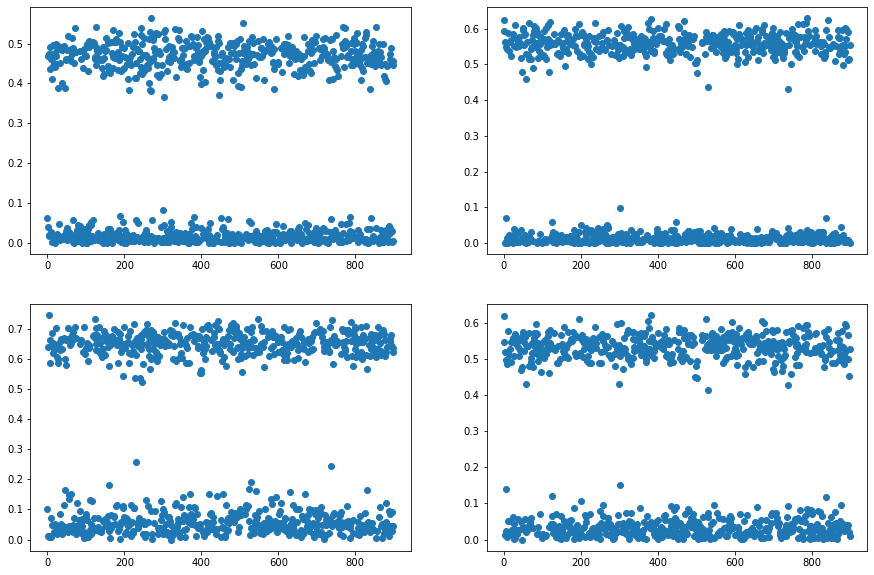

In [7]:
weight1, weight2 = weight_generate()
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax1 = plt.scatter(range(weight2.shape[1]), weight2[369])

ax2 = fig.add_subplot(222)
ax2 = plt.scatter(range(weight2.shape[1]), weight2[99])

ax3 = fig.add_subplot(223)
ax3 = plt.scatter(range(weight2.shape[1]), weight2[321])

ax4 = fig.add_subplot(224)
ax4 = plt.scatter(range(weight2.shape[1]), weight2[47])

## Slove the problem   

  <center>$min \sum_{i=1}^l\sum_{j=1}^u {w_i}_j(y^j - \overline{y^i})^2 + \frac{1}{2}\sum_{i=1}^u \sum_{j=1}^u {\overline{w}_i}_j(y^i - y^j)^2$</center>   
   
   Have $l$ labeled examples $(\overline{x^i},\overline{y^i}),  i = 1,\ldots, l$  
   
   Have $u$ unlabeled examples $ x^j,  j = 1,\ldots, u$    
   
   Have ${w_i}_j$:  similarity between labeled examples $i$ and unlabeled examples $j$ 
   
   Have ${{\overline{w}}_i}_j$:  similarity between unlabeled examples $j$      
       
   The gradient of $y^j$ is   
   <center>$2\sum_{i=1}^l {w_i}_j (y^j - \overline{y^i}) + 2\sum_{i=1}^u {{\overline{w}}_i}_j (y^j - y^i)$</center>   

In [8]:
weight1, weight2 = weight_generate()
# scaling
weight1 /= 1e6
weight2 /= 1e6


def gradient(y_j, y_label=y_label, w=weight1, w_bar=weight2):
    # the function must be general and no depending on this particular dataset
    gra1 = 2 * np.sum(w.T.dot(y_j.reshape(1,y_j.shape[0]) - y_label.reshape(y_label.shape[0], 1)), axis=-1)
#     print('gra1\n', gra1.shape)
    gra2 = 2 * np.sum(w_bar.T.dot(y_j.reshape(1,y_j.shape[0]) - y_j.reshape((y_j.shape[0]), 1)), axis=-1)
#     print('gra2\n', gra2.shape)
    return gra1+gra2
     
    
grad = gradient(np.ones(shape=(900,)))
print('grad.shape:',grad.shape)
# print('grad:',grad)


def f(y, y_label=y_label, w=weight1, w_bar=weight2):
    t11 = (y.reshape(1,y.shape[0])-y_label.reshape(y_label.shape[0],1))**2
    t1 = np.sum(w.T.dot(t11))
    t22 = (y.reshape(1,y.shape[0])-y.reshape(y.shape[0],1))**2
    t2 = np.sum(w_bar.T.dot(t22))/2

    return t1+t2


print('y=np.ones:', f(np.ones(shape=(900,))))

grad.shape: (900,)
y=np.ones: 62.21843505122646


###  Basic GD algoritm with fixed step

gradient=0
GD iterations: 949
GD CPU times: 48.04511450000001


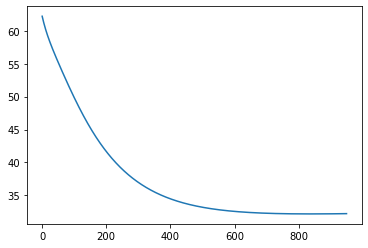

In [9]:
weight1, weight2 = weight_generate()
# scaling
weight1 /= 1e6
weight2 /= 1e6

maxit = 1000
epslion = 1e-1 
N_predict = 900
alpha = 5e-2

x_k = np.ones(shape=(N_predict,))
f_values = [f(x_k)]

start = time.perf_counter()
for step in range(maxit):
    g_k = gradient(x_k)
    if np.linalg.norm(g_k) < epslion:
        print('gradient=0')
        print('GD iterations:', step)
        break
    x_k = x_k - 1*alpha*g_k 
#     if f_values[step-1] - f(x_k) < 1e-7:
#         print('iterations:',step)
#         break
    f_values.append(f(x_k))
    
end = time.perf_counter()
print ('GD CPU times:', end-start)    
plt.plot(range(len(f_values)), f_values)

In [10]:
x_k = -x_k
x_k[x_k > 0] = 1
x_k[x_k < 0] = -1

accuary = balanced_accuracy_score(y_unlabel, x_k)
print('accuary:',accuary)
print(confusion_matrix(x_k, y_unlabel))

accuary: 0.9510071654674839
[[406   1]
 [ 43 450]]


### Randomized BCGD with fixed step

gradient=0
BCGD iterations: 949
BCGD CPU times: 50.10999289999995


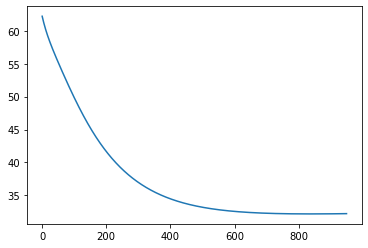

In [11]:
weight1, weight2 = weight_generate()
# scaling
weight1 /= 1e6
weight2 /= 1e6

maxit = 1000
epslion = 1e-1 
N_predict = 900
alpha = 0.5e-1

x_k = np.ones(shape=(N_predict,))
u = np.zeros_like(x_k)
f_values = [f(x_k)]

start = time.perf_counter()
for step in range(maxit):
    g_k = gradient(x_k)

    def gradient_bcgd(y_j, k_i, y_label=y_label, w=weight1, w_bar=weight2):
        gra1 = 2 * np.sum(w[:,k_i].T.dot(y_j.reshape(1,y_j.shape[0]) - y_label.reshape(y_label.shape[0], 1)), axis=-1)
        gra2 = 2 * np.sum(w_bar[:,k_i].T.dot(y_j.reshape(1,y_j.shape[0]) - y_j.reshape((y_j.shape[0]), 1)), axis=-1)
        return gra1+gra2

    if np.linalg.norm(g_k) < epslion:
        print('gradient=0')
        print('BCGD iterations:', step)
        break
    k_i = np.random.randint(0,900)
    g_k[k_i]= gradient_bcgd(x_k, k_i)
    x_k = x_k - 1*alpha*g_k
        
    f_values.append(f(x_k))
 
end = time.perf_counter()
print ('BCGD CPU times:', end-start)   
plt.plot(range(len(f_values)), f_values)

In [12]:
x_k = -x_k
x_k[x_k > 0] = 1
x_k[x_k < 0] = -1

accuary = balanced_accuracy_score(y_unlabel, x_k)
print('accuary:',accuary)
print(confusion_matrix(x_k, y_unlabel))

accuary: 0.9510071654674839
[[406   1]
 [ 43 450]]


### Cyclic BCGD with fixed step

gradient=0
Cyclic iterations: 949
Cyclic CPU times: 159.25039379999998


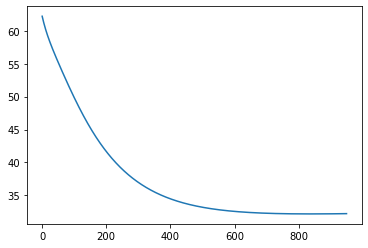

In [27]:
weight1, weight2 = weight_generate()
# scaling
weight1 /= 1e6
weight2 /= 1e6

maxit = 2000
epslion = 1e-1 
N_predict = 900
alpha = 0.5e-1

x_k = np.ones(shape=(N_predict,))
u = np.zeros_like(x_k)
f_values = [f(x_k)]

start = time.perf_counter()
for step in range(maxit):
#     print('step ', step)
    g_k = gradient(x_k)
    
    if np.linalg.norm(g_k) < epslion:
        print('gradient=0')
        print('Cyclic iterations:', step)
        break
    for i in range(len(x_k)):
        u[i] = 1
        x_k = x_k - 1*alpha*g_k*u
        u[i] = 0
    
    f_values.append(f(x_k))
 
end = time.perf_counter()
print ('Cyclic CPU times:', end-start)   
plt.plot(range(len(f_values)), f_values)

In [28]:
x_k = -x_k
x_k[x_k > 0] = 1
x_k[x_k < 0] = -1

accuary = balanced_accuracy_score(y_unlabel, x_k)
print('accuary:',accuary)
print(confusion_matrix(x_k, y_unlabel))

accuary: 0.9510071654674839
[[406   1]
 [ 43 450]]
